# Сборный проект

Для интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры необходимо выявить закономерности определяющие успешность игры на основе данных из открытых источников, в которых доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Цели:
- Какие самые прибыльные жанры игр? Выделяются ли жанры с высокими и низкими продажами?
- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

## Содержание
* [Обзор данных](#first-bullet)
* [Предобработка данных](#second-bullet)
* [Исследовательский анализ данных](#third-bullet)
* [Портрет пользователей по регионам](#fourth-bullet)
* [Проверка гипотез](#fifth-bullet)
* [Общий вывод](#sixth-bullet)

**Ход исследования**

Данные я получу из файла `games.csv`

Я проверю данные на дубликаты и пропуски и устраню их по возможности.

Таким образом мое исследование пройдет в 6 этапов:
- Обзор данных
- Предобработка данных
- Исследовательский анализ данных
- Проверка гипотез
- Общий вывод

In [2]:
pip -q install missingno


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import missingno as msno

<a class="anchor" id="first-bullet"></a>
## Обзор данных

In [5]:
data = pd.read_csv('games.csv')
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


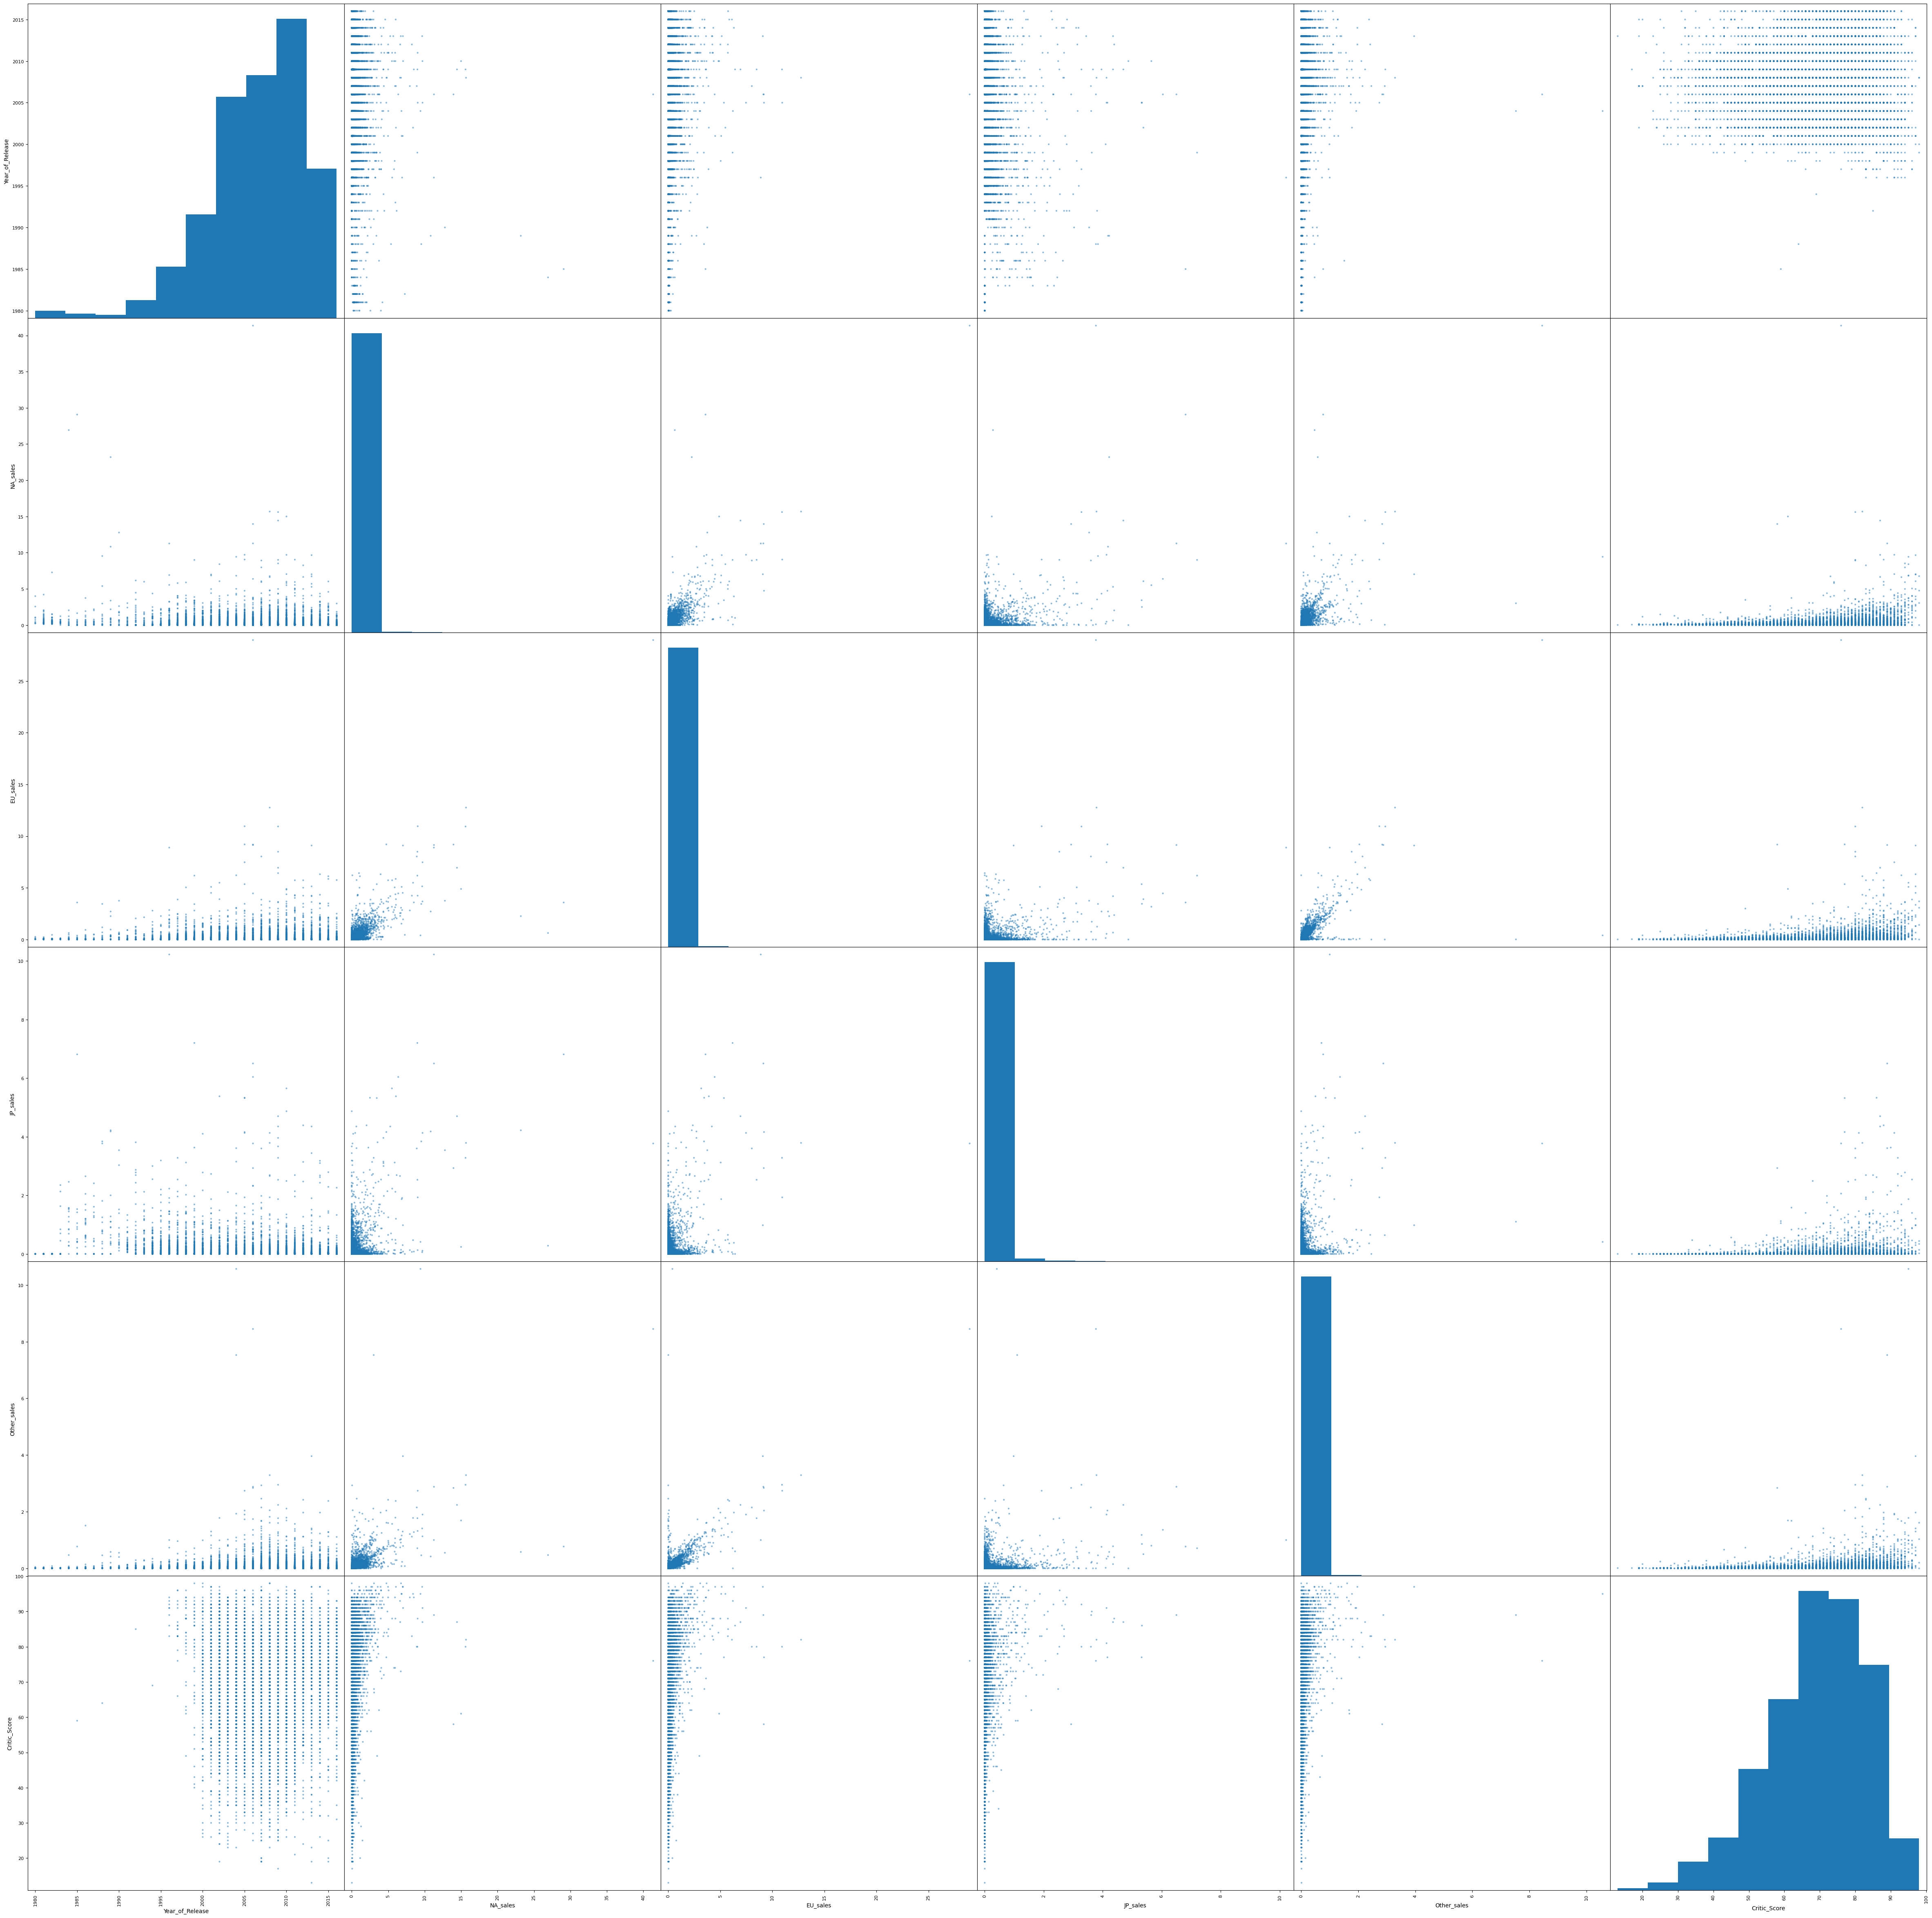

In [7]:
pd.plotting.scatter_matrix(data.select_dtypes(include='number'), figsize=(60, 60))
plt.show()

По резульатам ознакомления с данными можно сказать, что у нас есть одна таблица, в ней точно есть пропуски и типы данных не везде правильные

<a class="anchor" id="second-bullet"></a>
## Предобработка данных

In [10]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'year_of_release': 'year'})

In [11]:
data['year'] = data['year'].astype('Int32')
data['critic_score'] = data['critic_score'].astype('Int32')
data['user_score'] = data['user_score'].replace({'tbd': np.nan})
data['user_score'] = data['user_score'].astype('float32')

In [12]:
data.duplicated().sum()

0

In [13]:
data.isna().sum()

name               2
platform           0
year             269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      9125
rating          6766
dtype: int64

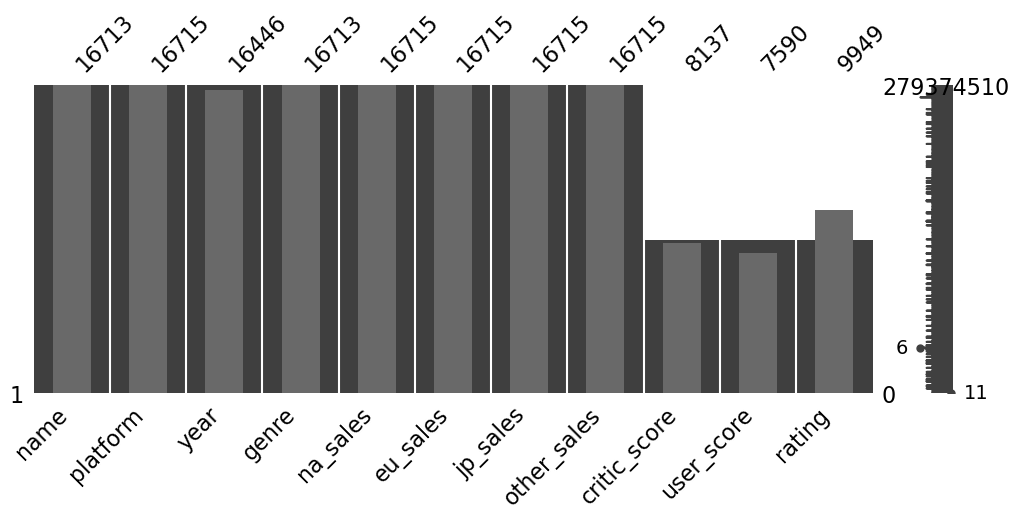

In [14]:
msno.matrix(data, figsize=(12, 6))
msno.bar(data, figsize=(12, 4))
plt.show()

В данных довольно много пропусков и вот как я считаю лучше поступить с каждым из них:
- `name` удалить две строки без названия
- `year` данные с пропусками составляют менее 2% так что лучше удалить, чтобы не искажать исследование
- `genre` удалить две строки без названия
- `critic_score` Оставить NaN, потому что многие игры просто не рецензировались, а при построении диаграмм и других вычислений просто их не учитывать
- `user_score` аналогично `critic_score`
- `rating` заменить NaN на `NR` = Not Rated

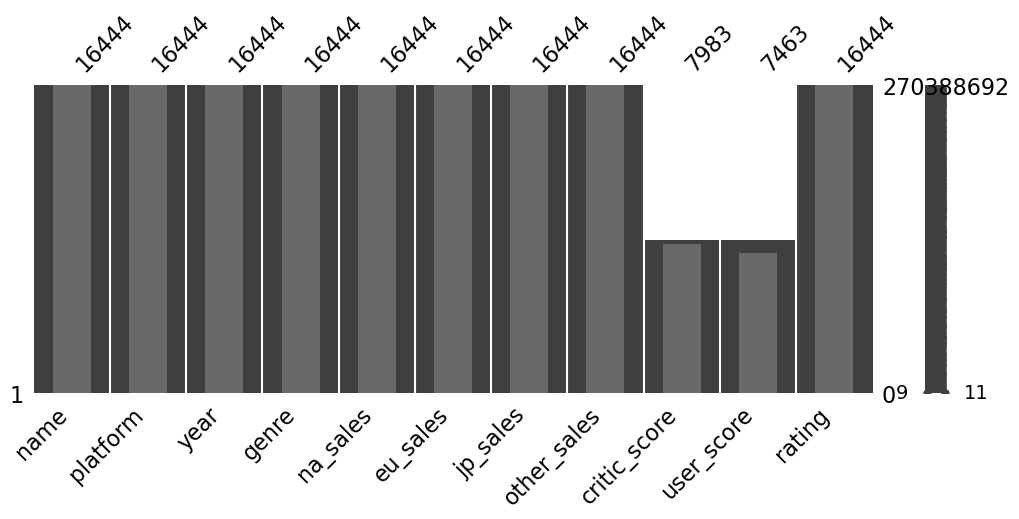

In [16]:
data = data.dropna(subset=['name','genre','year'])
data['rating'] = data['rating'].fillna('NR')
msno.matrix(data, figsize=(12, 6))
msno.bar(data, figsize=(12, 4))
plt.show()

In [17]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

По результатам предобработки мы избавились от пропусков, мешающих анализу, проверили отсутсвие дубликатов, создали новый столбец `total_sales` с суммарными продажами

<a class="anchor" id="third-bullet"></a>
## Исследовательский анализ данных

### Количество игр по годам

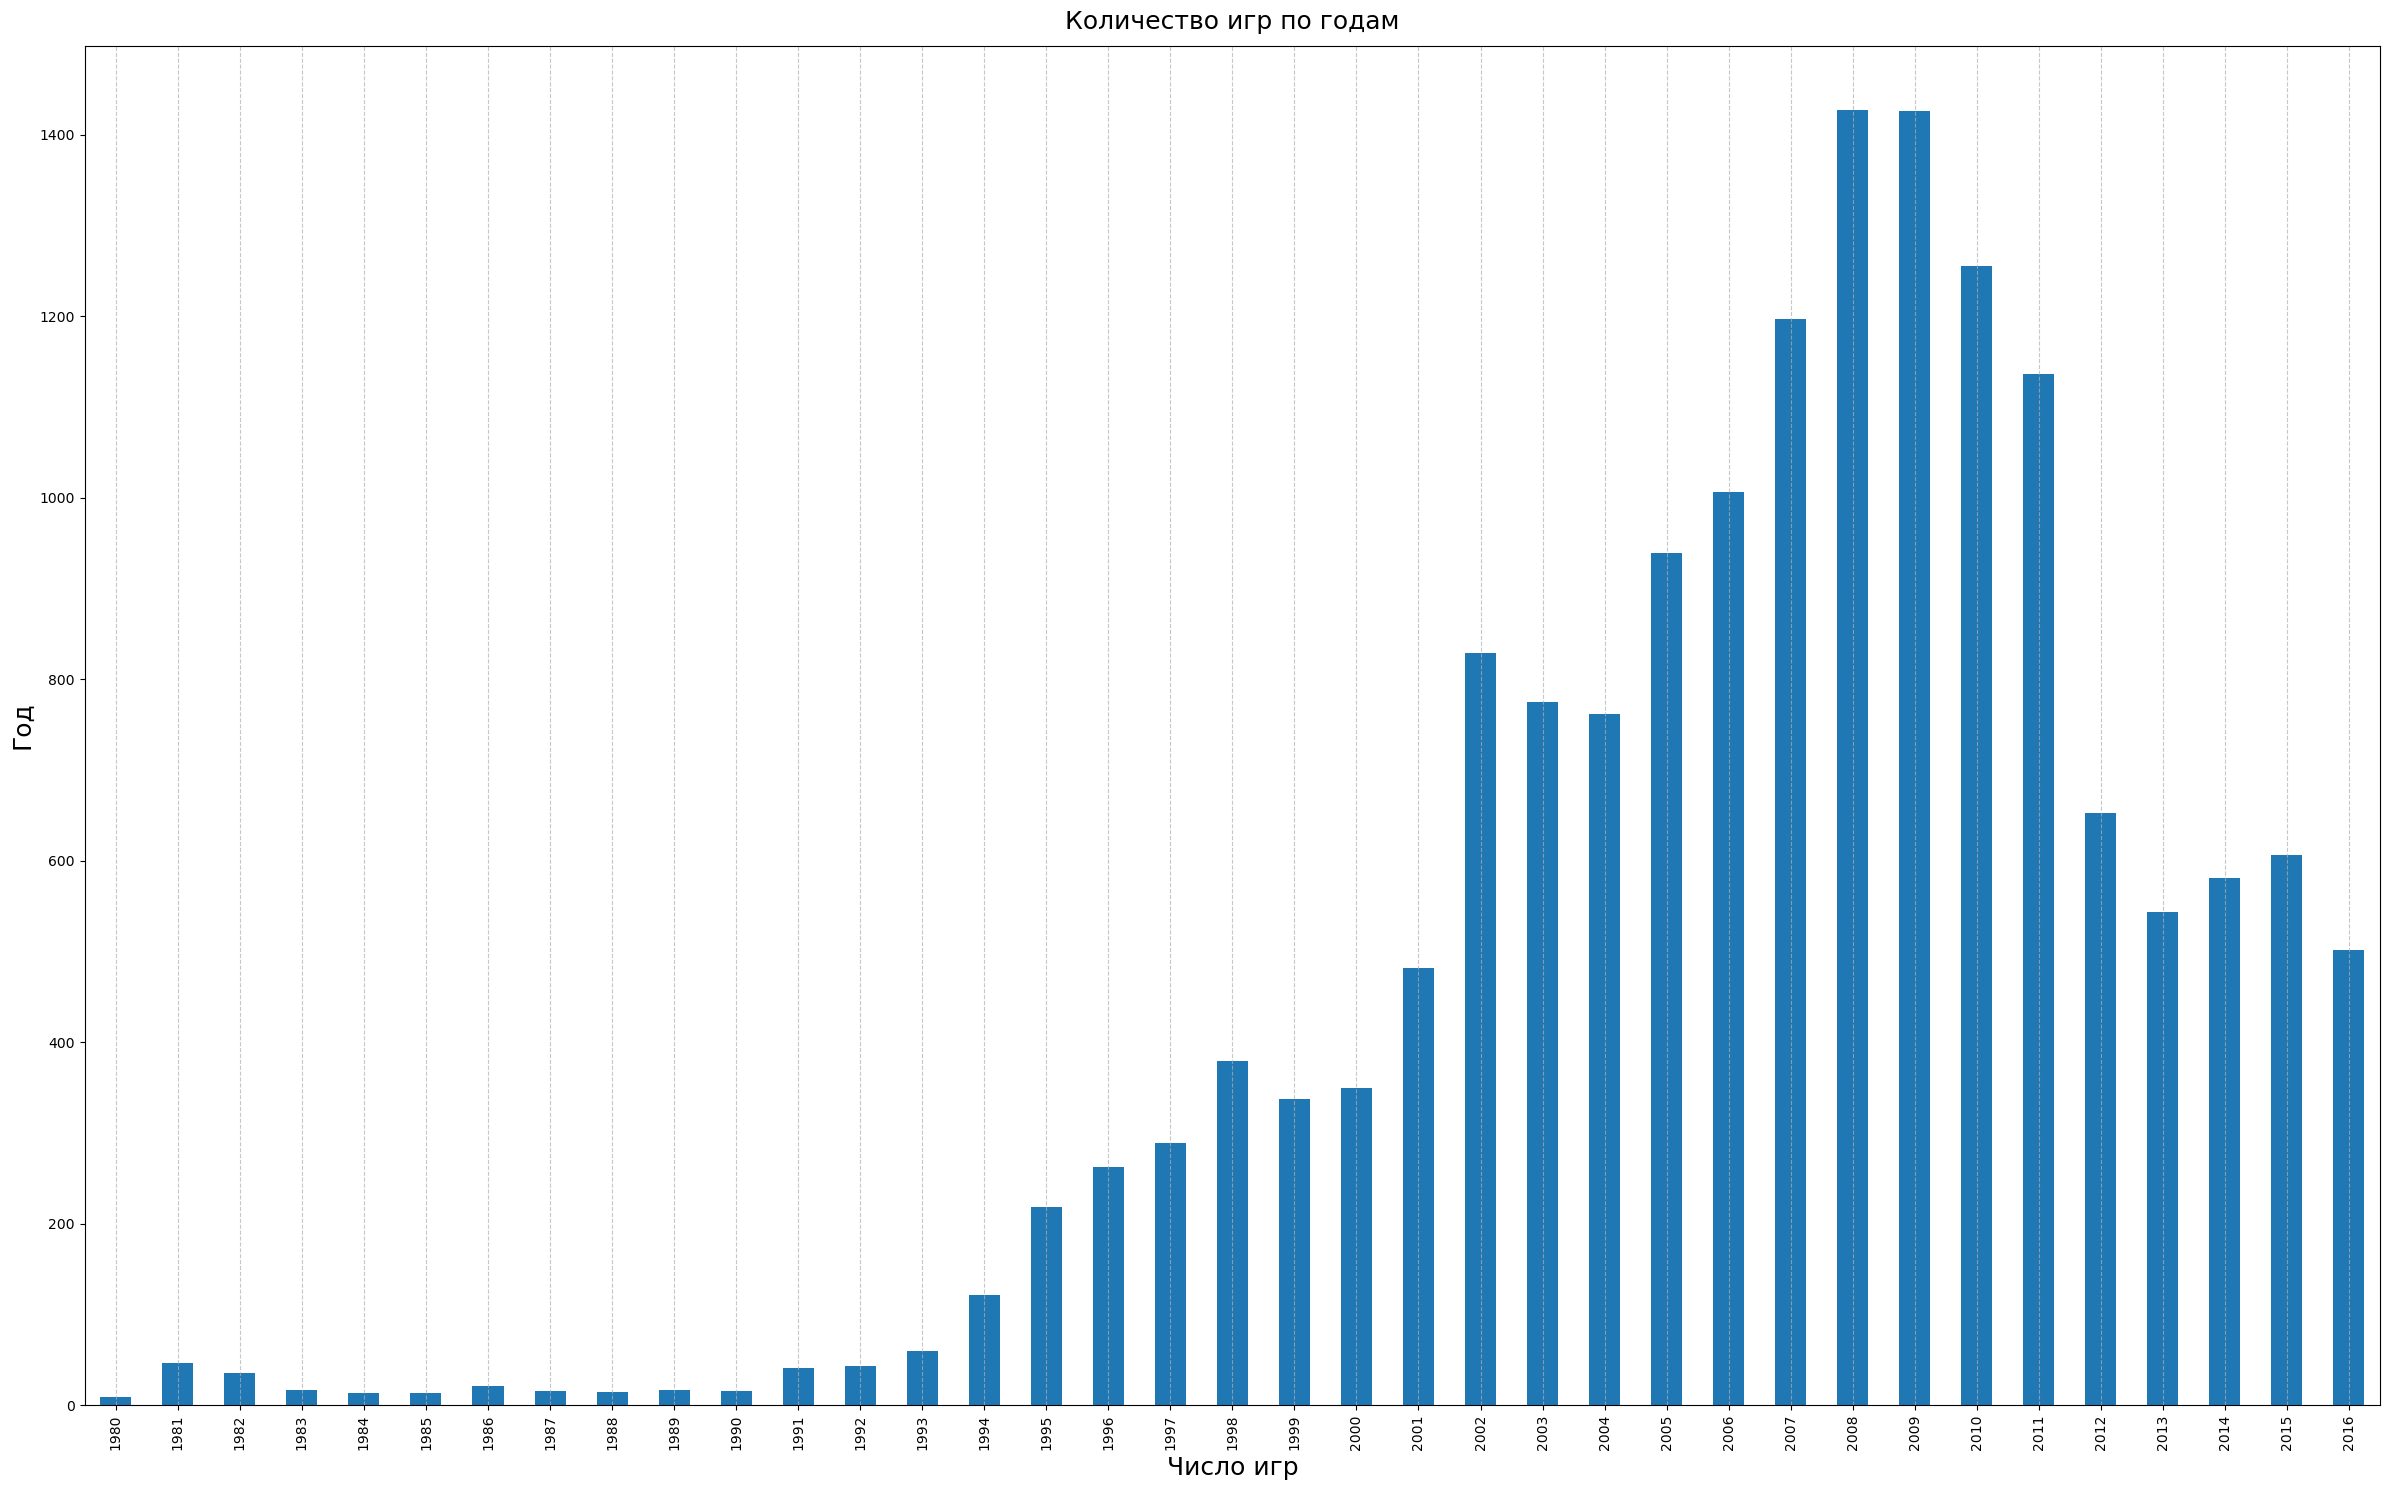

In [21]:
group_year = data.groupby('year')['name'].count()
plt.figure(figsize=(24, 15)) 
ax = group_year.plot.bar()
ax.set_title('Количество игр по годам', fontsize=18, pad=12)
ax.set_xlabel('Число игр', fontsize=18)
ax.set_ylabel('Год', fontsize=18)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Видно, что пик был в 2005-2011 годах, но в целом игр выпускалось сильно больше с 2001, чем до этого

### Продажи по платформам

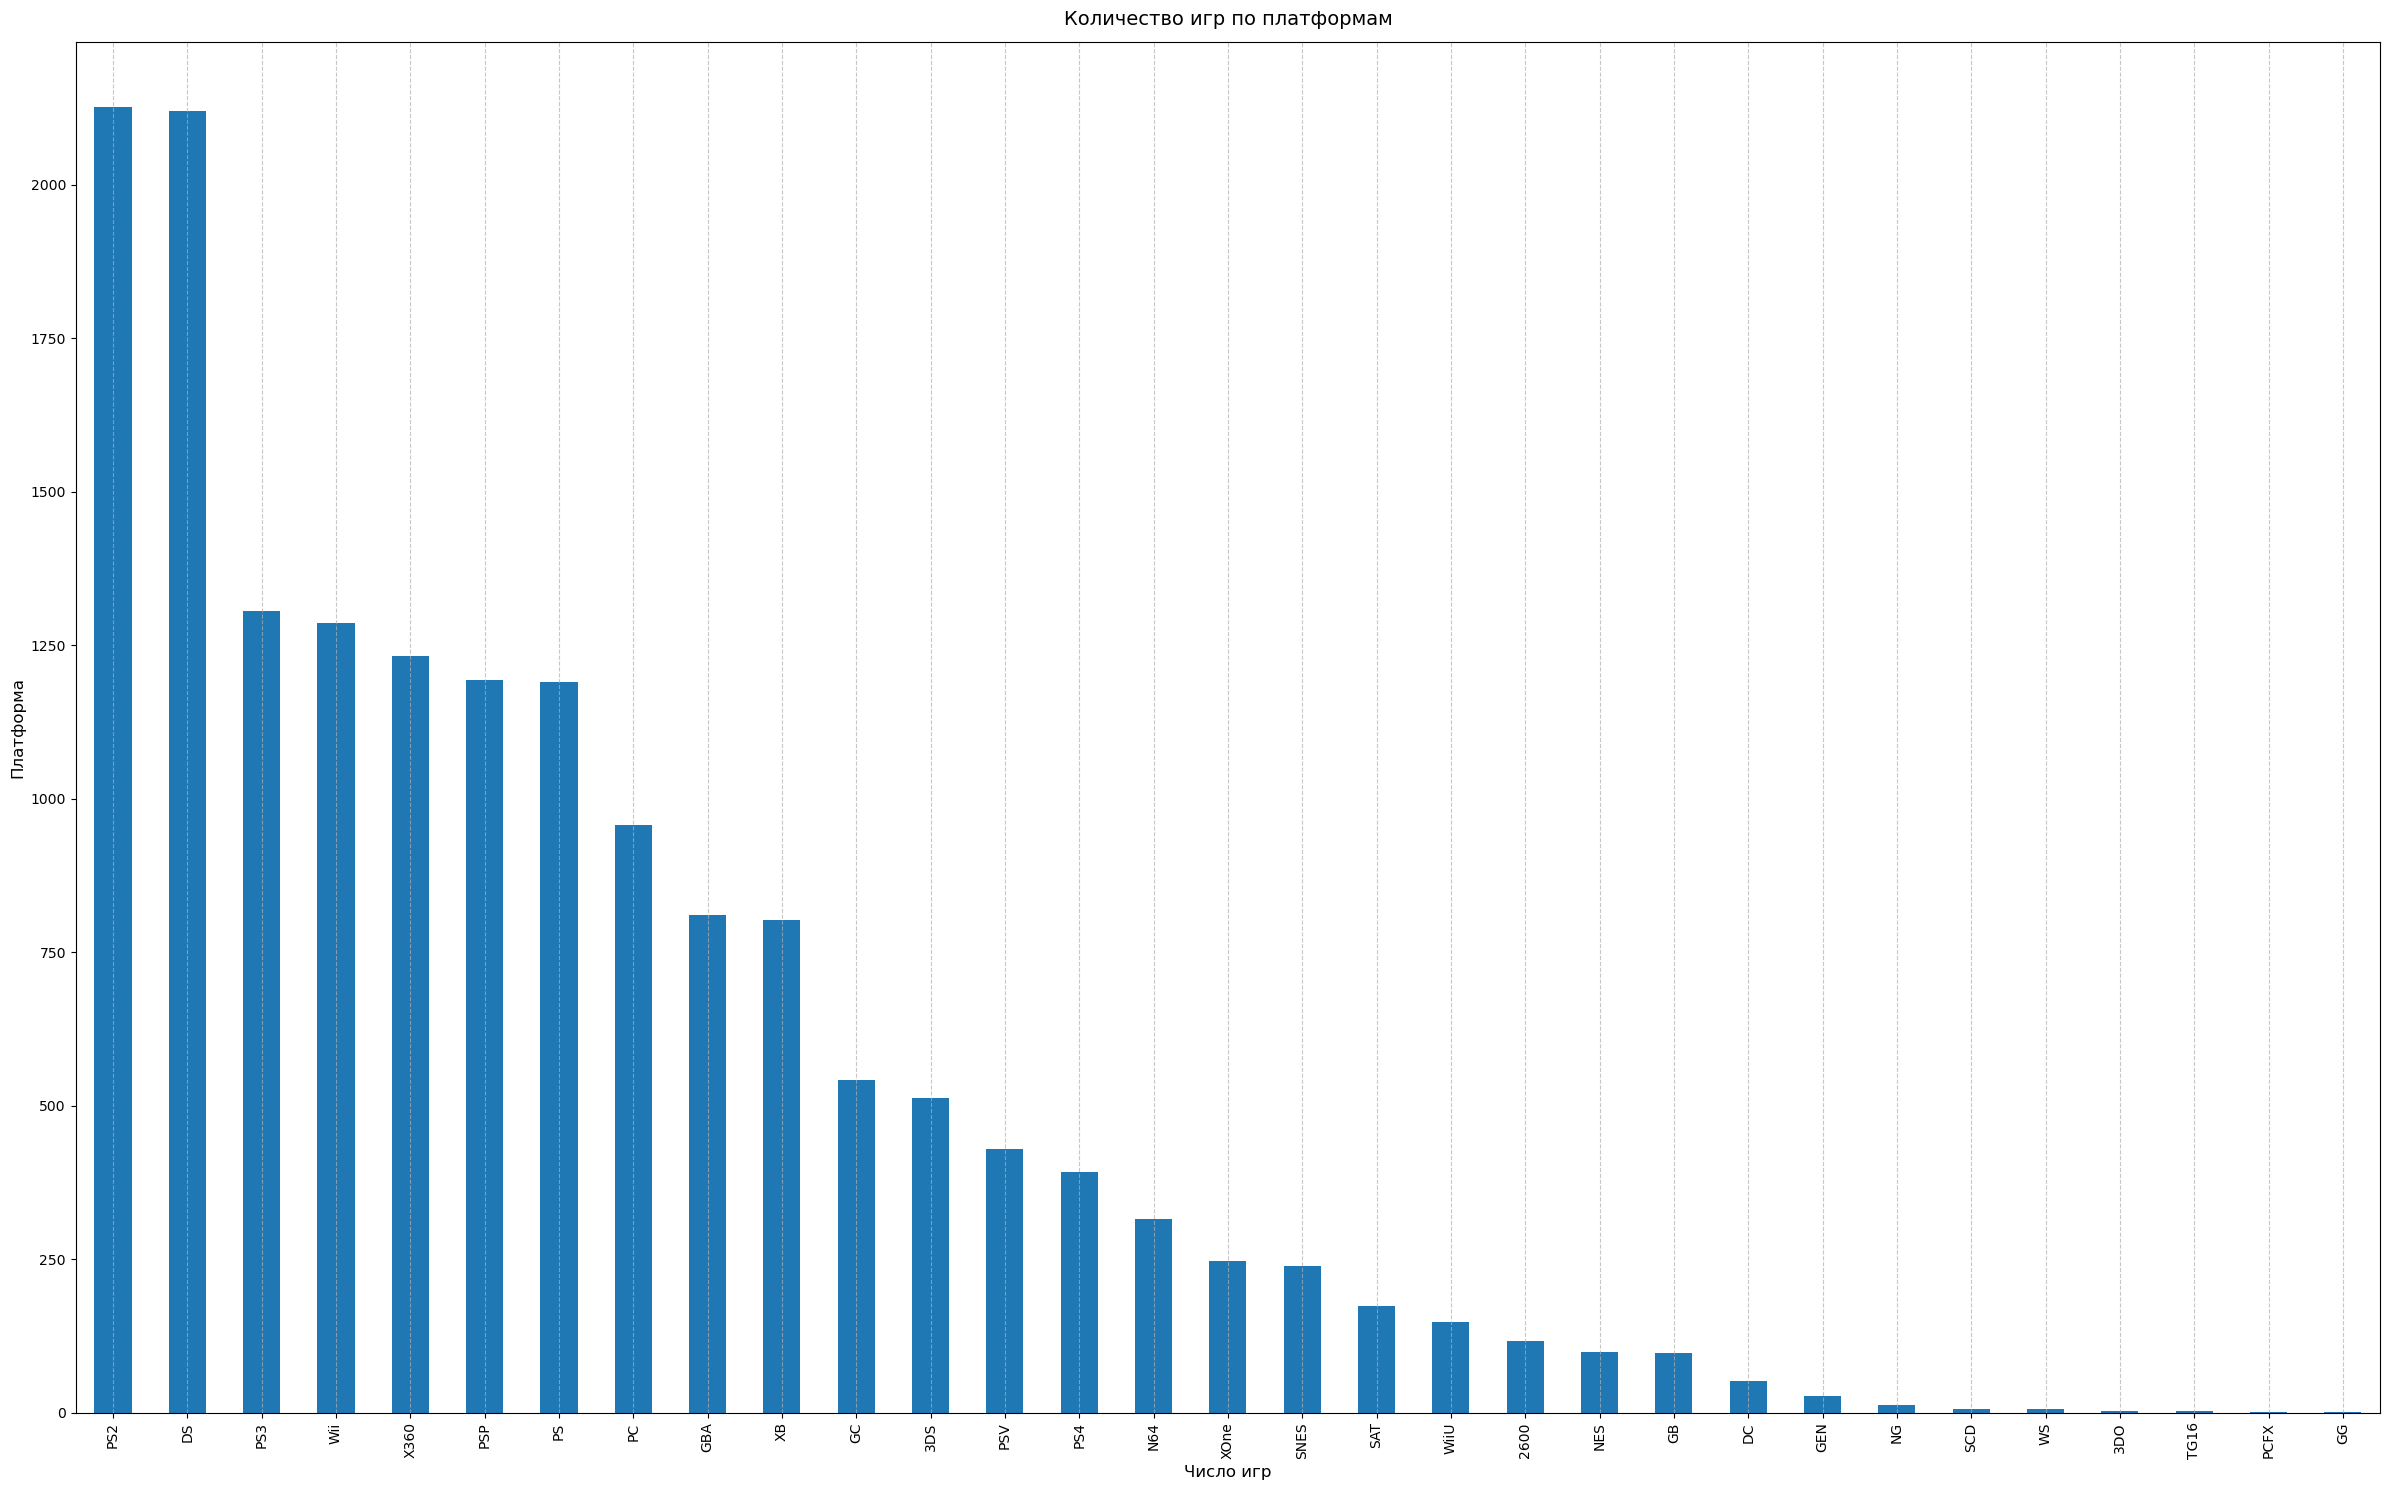

In [24]:
group_platform = data.groupby('platform')['name'].count().sort_values(ascending=False)
plt.figure(figsize=(24, 15))
ax = group_platform.plot.bar()
ax.set_title('Количество игр по платформам', fontsize=14, pad=12)
ax.set_xlabel('Число игр', fontsize=12)
ax.set_ylabel('Платформа', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Очевиден отрыв PlayStation2 и Nintendo DS от остальных конкурентов, тем не менее дальше идет игры на PS3, Wii, X360, PSP, PS и PC

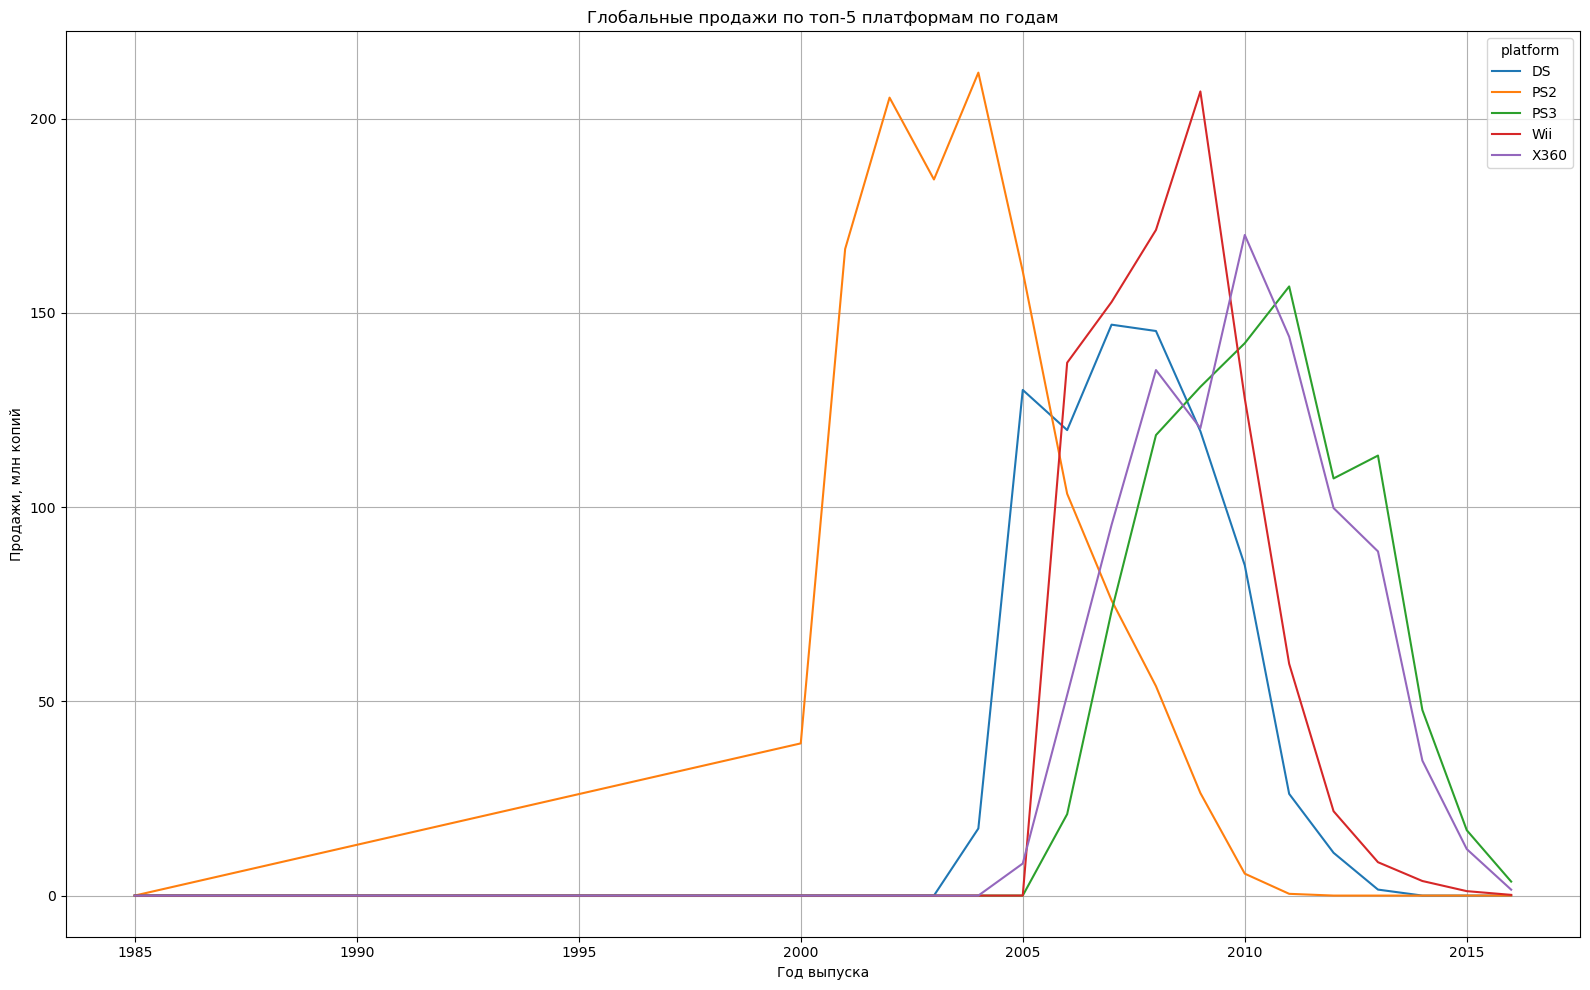

In [26]:
top5 = (
    data
    .groupby('platform')['total_sales']
    .sum()
    .nlargest(5)
    .index
    .tolist()
)
df_top5 = data[data['platform'].isin(top5)]
sales_yearly = (
    df_top5
    .groupby(['year','platform'])['total_sales']
    .sum()
    .unstack(fill_value=0)
)
sales_yearly.plot(figsize=(16, 10))
plt.title('Глобальные продажи по топ-5 платформам по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Продажи, млн копий')
plt.grid(True)
plt.tight_layout()
plt.show()

На графике видно, что в среднем платформы после выпуска достигают пика по продадам через 3-5 лет после выпуска, а потом медленно угасают за 5-10 лет

### Анализ по актуальным данным

In [29]:
data_act = data[data['year'] >= 2012].copy()

Я выбрал данные с 2012 года, так как индустрия игр быстро меняется и это оптимальный срок

In [31]:
sales_sum = (
    data_act
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)
print(sales_sum.head(8))

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Name: total_sales, dtype: float64


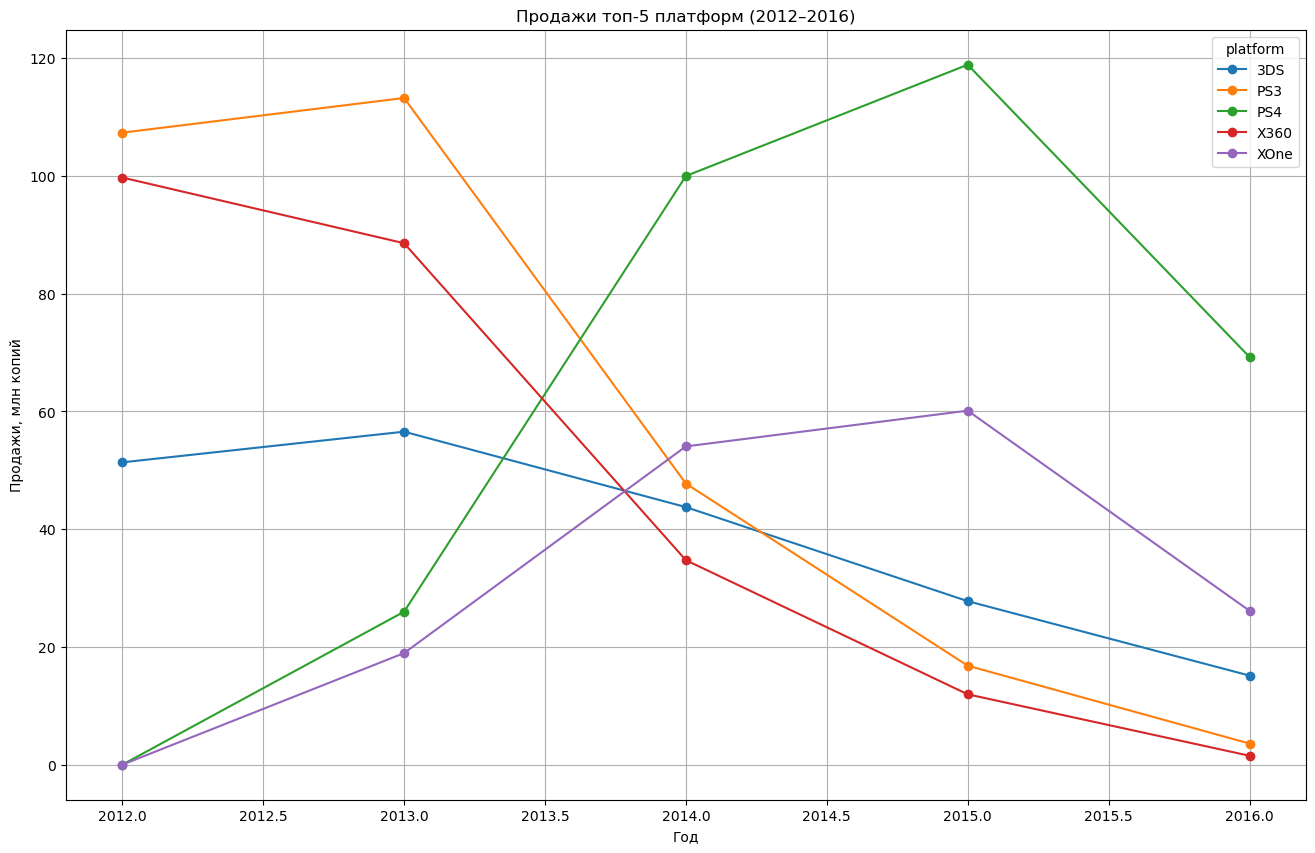

In [32]:
top5 = sales_sum.head(5).index
df5 = data_act[data_act['platform'].isin(top5)]
trend = (df5
         .groupby(['year','platform'])['total_sales']
         .sum()
         .unstack(fill_value=0))
trend.plot(marker='o', figsize=(16, 10))
plt.title('Продажи топ-5 платформ (2012–2016)')
plt.xlabel('Год')
plt.ylabel('Продажи, млн копий')
plt.grid()
plt.show()

<Figure size 800x600 with 0 Axes>

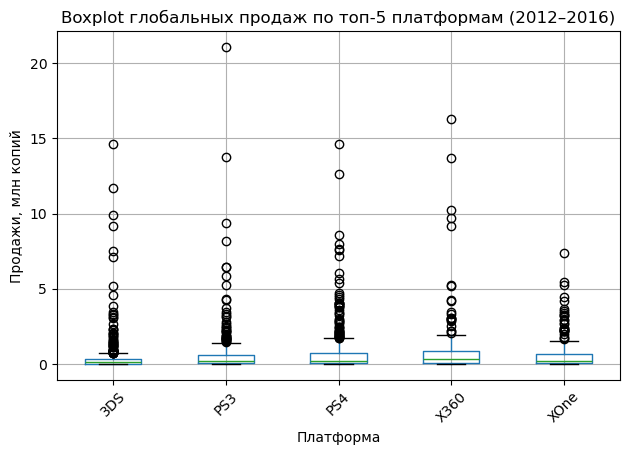

In [33]:
plt.figure(figsize=(8,6))
data_act[data_act['platform'].isin(top5)] \
    .boxplot(column='total_sales', by='platform', rot=45)
plt.title('Boxplot глобальных продаж по топ-5 платформам (2012–2016)')
plt.suptitle('')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн копий')
plt.tight_layout()
plt.show()

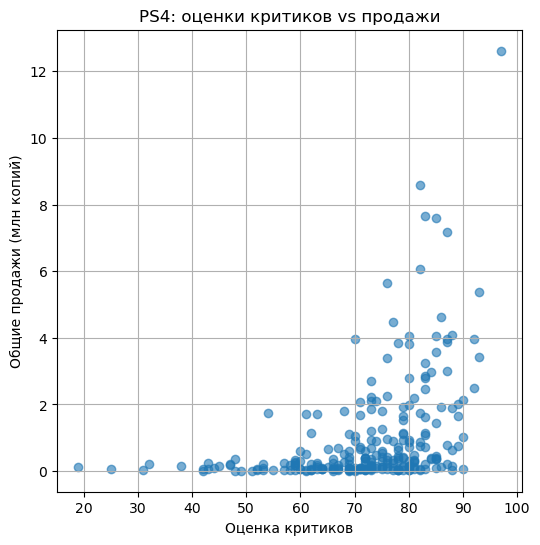

Корреляция оценка критиков ↔ общие продажи: 0.406


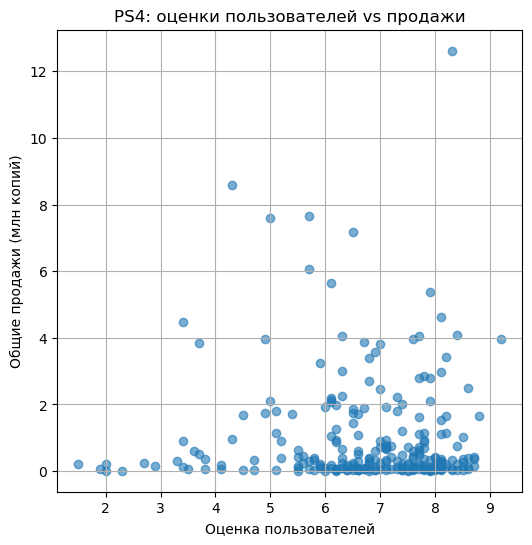

Корреляция оценка пользователей ↔ общие продажи: -0.034


In [34]:
ps4 = (
    data_act
    .loc[data_act['platform']=='PS4', 
         ['critic_score','user_score','total_sales']]
    .dropna()
)
plt.figure(figsize=(6,6))
plt.scatter(ps4['critic_score'], ps4['total_sales'], alpha=0.6)
plt.xlabel('Оценка критиков')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS4: оценки критиков vs продажи')
plt.grid()
plt.show()
corr_matrix = ps4.corr()
print('Корреляция оценка критиков ↔ общие продажи:', round(corr_matrix.loc['critic_score','total_sales'],3))
plt.figure(figsize=(6,6))
plt.scatter(ps4['user_score'], ps4['total_sales'], alpha=0.6)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS4: оценки пользователей vs продажи')
plt.grid()
plt.show()

print('Корреляция оценка пользователей ↔ общие продажи:', round(corr_matrix.loc['user_score'  ,'total_sales'],3))

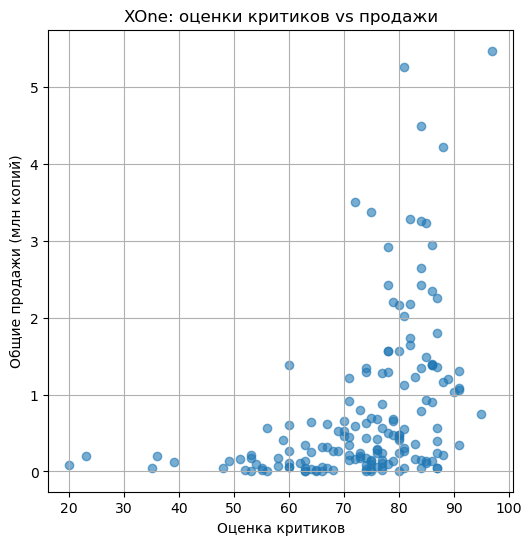

Корреляция оценка критиков ↔ общие продажи: 0.41


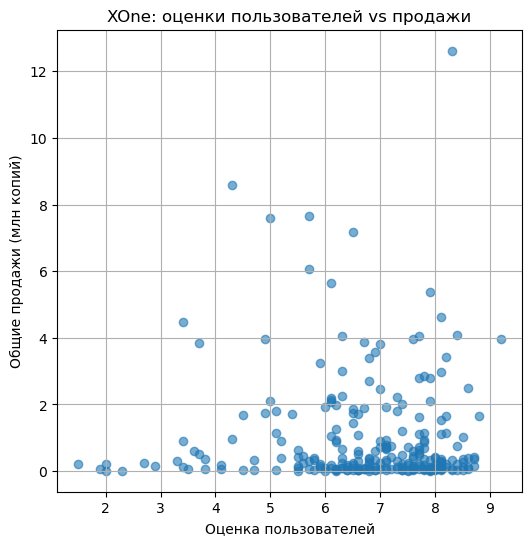

Корреляция оценка пользователей ↔ общие продажи: -0.094


In [35]:
xone = (
    data_act
    .loc[data_act['platform']=='XOne', 
         ['critic_score','user_score','total_sales']]
    .dropna()
)
plt.figure(figsize=(6,6))
plt.scatter(xone['critic_score'], xone['total_sales'], alpha=0.6)
plt.xlabel('Оценка критиков')
plt.ylabel('Общие продажи (млн копий)')
plt.title('XOne: оценки критиков vs продажи')
plt.grid()
plt.show()
corr_matrix = xone.corr()
print('Корреляция оценка критиков ↔ общие продажи:', round(corr_matrix.loc['critic_score','total_sales'],3))
plt.figure(figsize=(6,6))
plt.scatter(ps4['user_score'], ps4['total_sales'], alpha=0.6)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общие продажи (млн копий)')
plt.title('XOne: оценки пользователей vs продажи')
plt.grid()
plt.show()

print('Корреляция оценка пользователей ↔ общие продажи:', round(corr_matrix.loc['user_score'  ,'total_sales'],3))

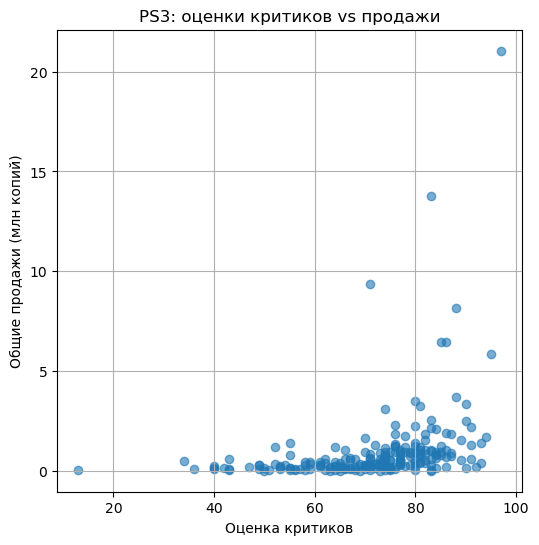

Корреляция оценка критиков ↔ общие продажи: 0.331


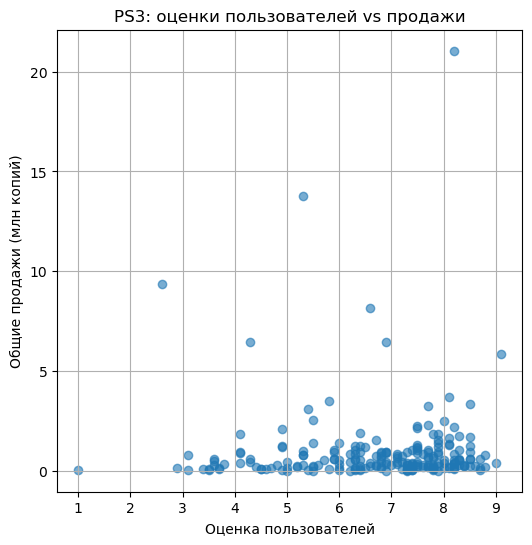

Корреляция оценка пользователей ↔ общие продажи: 0.003


In [36]:
ps3 = (
    data_act
    .loc[data_act['platform']=='PS3', 
         ['critic_score','user_score','total_sales']]
    .dropna()
)
plt.figure(figsize=(6,6))
plt.scatter(ps3['critic_score'], ps3['total_sales'], alpha=0.6)
plt.xlabel('Оценка критиков')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS3: оценки критиков vs продажи')
plt.grid()
plt.show()
corr_matrix = ps3.corr()
print('Корреляция оценка критиков ↔ общие продажи:', round(corr_matrix.loc['critic_score','total_sales'],3))
plt.figure(figsize=(6,6))
plt.scatter(ps3['user_score'], ps3['total_sales'], alpha=0.6)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS3: оценки пользователей vs продажи')
plt.grid()
plt.show()

print('Корреляция оценка пользователей ↔ общие продажи:', round(corr_matrix.loc['user_score'  ,'total_sales'],3))

Можно заметить, что корреляции между оценками пользователей и продажами вообще нет, а между оценкой критиков и продажами она слабая

### Распределение по жанрам

              median      mean  count
genre                                
Shooter        0.440  1.296723    235
Sports         0.240  0.675634    268
Platform       0.210  0.717647     85
Role-Playing   0.140  0.521081    370
Racing         0.140  0.465217    115
Fighting       0.130  0.408165    109
Action         0.120  0.427856   1031
Misc           0.120  0.442917    192
Simulation     0.120  0.439000     80
Strategy       0.080  0.187887     71
Puzzle         0.045  0.174643     28
Adventure      0.030  0.097450    302


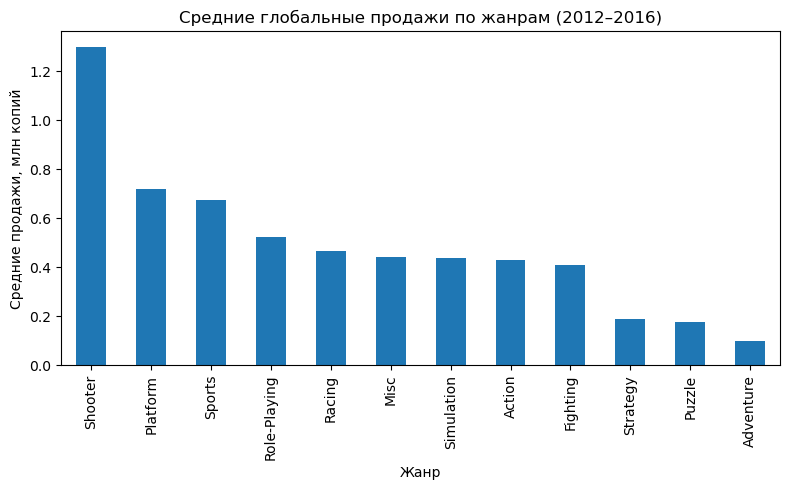

In [39]:
genre_stats = (
    data_act
    .groupby('genre')['total_sales']
    .agg(['median','mean','count'])
    .sort_values('median', ascending=False)
)
print(genre_stats)
genre_stats['mean'].sort_values(ascending=False).plot(
    kind='bar', figsize=(8,5)
)
plt.title('Средние глобальные продажи по жанрам (2012–2016)')
plt.xlabel('Жанр')
plt.ylabel('Средние продажи, млн копий')
plt.tight_layout()
plt.show()

Видна большая разница между популярными и не популярными жанрами, шутеры в разы популярнее приключенческих игр

<a class="anchor" id="fourth-bullet"></a>
## Портрет пользователей по регионам

                                       Доля, %     Категория
Регион           Тип          Место                         
Европа           Жанр         1      31.439170        Action
                              2      22.388619       Shooter
                              3      13.632059        Sports
                              4       9.575392  Role-Playing
                              5       5.384555        Racing
                 Платформа    1      27.838286           PS4
                              2      21.084409           PS3
                              3      14.703445          X360
                              4      10.179156          XOne
                              5       8.413243           3DS
                 Рейтинг ESRB 1      38.269997             M
                              2      22.301803             E
                              3      18.053747            NR
                              4      10.924983          E10+
                        

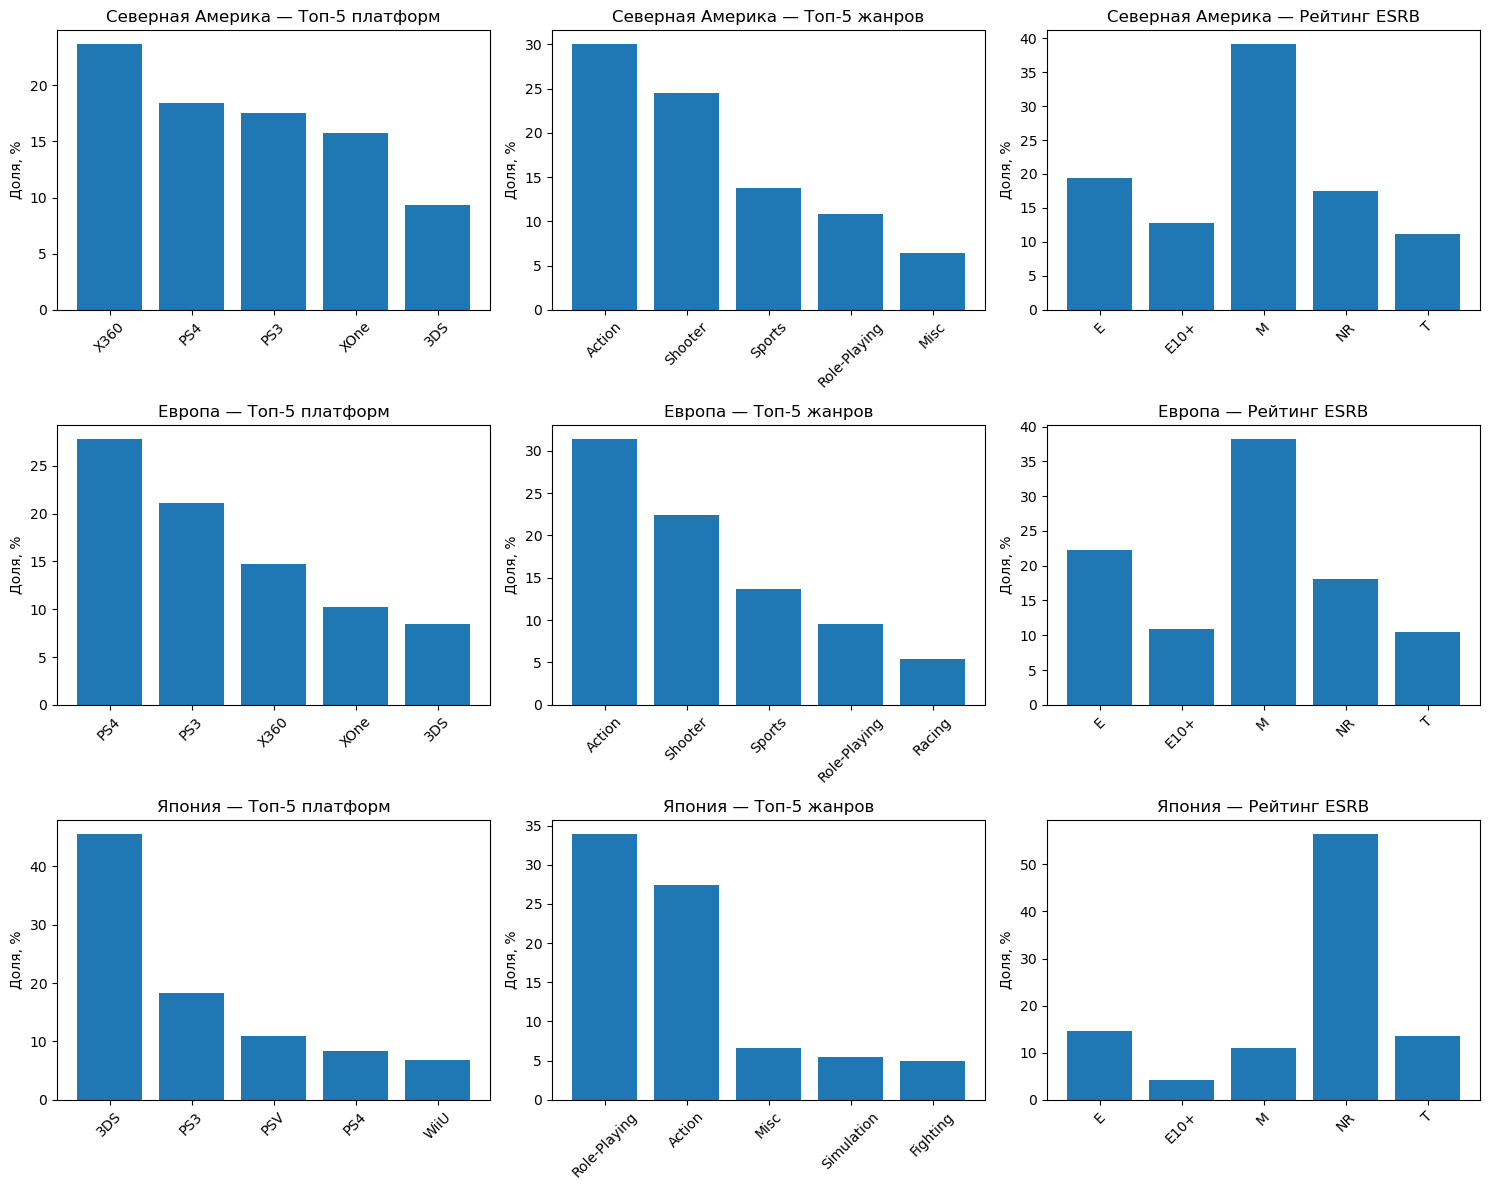

In [42]:
regions = {
    'na_sales': 'Северная Америка',
    'eu_sales': 'Европа',
    'jp_sales': 'Япония',
}

rows = []
for col, region in regions.items():
    total = data_act[col].sum()
    top_plat = (
        data_act
        .groupby('platform')[col]
        .sum()
        .nlargest(5)
    )
    top_gen  = (
        data_act
        .groupby('genre')[col]
        .sum()
        .nlargest(5)
    )
    dist_rat = (
        data_act
        .groupby('rating')[col]
        .sum()
        .sort_values(ascending=False)
    )

    for i, (plat, val) in enumerate(top_plat.items(), 1):
        rows.append([region, 'Платформа',    i, plat, val/total*100])
    for i, (gen, val) in enumerate(top_gen.items(), 1):
        rows.append([region, 'Жанр',          i, gen,  val/total*100])
    for i, (rat, val) in enumerate(dist_rat.items(), 1):
        rows.append([region, 'Рейтинг ESRB', i, rat,  val/total*100])

report = pd.DataFrame(rows, columns=['Регион','Тип','Место','Категория','Доля, %'])
pivot = report.pivot_table(
    index=['Регион','Тип','Место'],
    values=['Категория','Доля, %'],
    aggfunc={'Категория':'first','Доля, %':'first'}
).sort_index()

print(pivot)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, (col, region) in enumerate(regions.items()):
    s_plat = data_act.groupby('platform')[col].sum()
    s_plat = (s_plat / s_plat.sum() * 100).nlargest(5)
    axes[3*i].bar(s_plat.index, s_plat.values)
    axes[3*i].set_title(f'{region} — Топ-5 платформ')
    axes[3*i].tick_params(axis='x', rotation=45)
    axes[3*i].set_ylabel('Доля, %')

    s_gen = data_act.groupby('genre')[col].sum()
    s_gen = (s_gen / s_gen.sum() * 100).nlargest(5)
    axes[3*i+1].bar(s_gen.index, s_gen.values)
    axes[3*i+1].set_title(f'{region} — Топ-5 жанров')
    axes[3*i+1].tick_params(axis='x', rotation=45)
    axes[3*i+1].set_ylabel('Доля, %')

    s_rat = data_act.groupby('rating')[col].sum()
    s_rat = s_rat / s_rat.sum() * 100
    axes[3*i+2].bar(s_rat.index, s_rat.values)
    axes[3*i+2].set_title(f'{region} — Рейтинг ESRB')
    axes[3*i+2].tick_params(axis='x', rotation=45)
    axes[3*i+2].set_ylabel('Доля, %')

plt.tight_layout()
plt.show()

Можно заметить что тренды в Европе и Америке в целом похожи, главное отличие в игровой платформе, а вот с Японией различия большие во всех параметрах

<a class="anchor" id="fifth-bullet"></a>
## Проверка гипотез

H0 - Средние пользовательские рейтинги платформ Xbox One и PC равны

H1 - Средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [46]:
xone = data_act.loc[data_act['platform']=='XOne', 'user_score'].dropna()
pc   = data_act.loc[data_act['platform']=='PC',     'user_score'].dropna()
alpha = 0.05
stat1, p1 = st.ttest_ind(xone, pc, equal_var=False)
print(f'Xbox One vs PC: t={stat1:.3f}, p={p1:.3f}')
if p1 < alpha:
    print('Отвергаем H0, средние различаются.')
else:
    print('Нет оснований отвергать H0 — средние не отличаются.')

Xbox One vs PC: t=0.600, p=0.549
Нет оснований отвергать H0 — средние не отличаются.


H0 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны.

H1 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

In [48]:
action = data_act.loc[data_act['genre']=='Action', 'user_score'].dropna()
sports = data_act.loc[data_act['genre']=='Sports','user_score'].dropna()
stat2, p2 = st.ttest_ind(action, sports, equal_var=False)
print(f'\nAction vs Sports:  t={stat2:.3f}, p={p2:.3f}')
if p2 < alpha:
    print('Отвергаем H0, средние различаются.')
else:
    print('Нет оснований отвергать H0 — средние не отличаются.')


Action vs Sports:  t=9.903, p=0.000
Отвергаем H0, средние различаются.


<a class="anchor" id="sixth-bullet"></a>
## Общий вывод

В резульате анализа я выяснил следующее для данных за 2012-2016 года, которые я принял за актульный период:
- Корреляции между оценками критиков и пользователей и продажами нет, либо она очень слабая

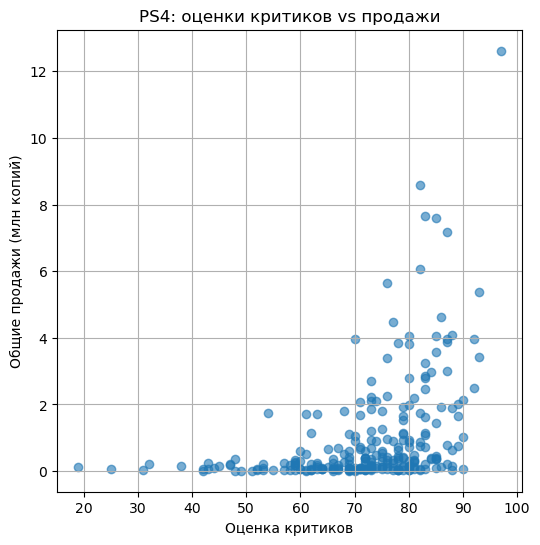

Корреляция оценка критиков ↔ общие продажи: 0.406


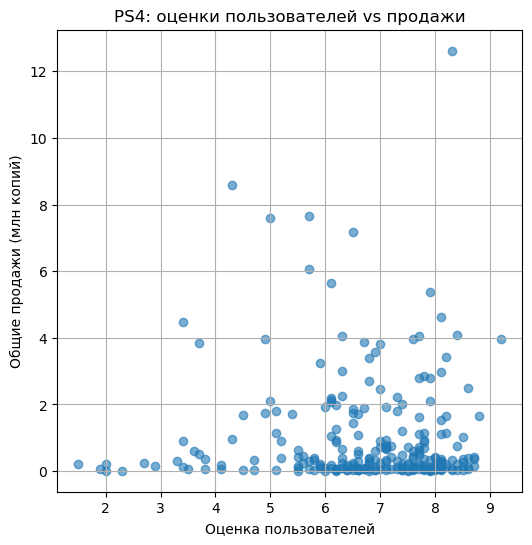

Корреляция оценка пользователей ↔ общие продажи: -0.034


In [51]:
ps4 = (
    data_act
    .loc[data_act['platform']=='PS4', 
         ['critic_score','user_score','total_sales']]
    .dropna()
)
plt.figure(figsize=(6,6))
plt.scatter(ps4['critic_score'], ps4['total_sales'], alpha=0.6)
plt.xlabel('Оценка критиков')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS4: оценки критиков vs продажи')
plt.grid()
plt.show()
corr_matrix = ps4.corr()
print('Корреляция оценка критиков ↔ общие продажи:', round(corr_matrix.loc['critic_score','total_sales'],3))
plt.figure(figsize=(6,6))
plt.scatter(ps4['user_score'], ps4['total_sales'], alpha=0.6)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS4: оценки пользователей vs продажи')
plt.grid()
plt.show()

print('Корреляция оценка пользователей ↔ общие продажи:', round(corr_matrix.loc['user_score'  ,'total_sales'],3))

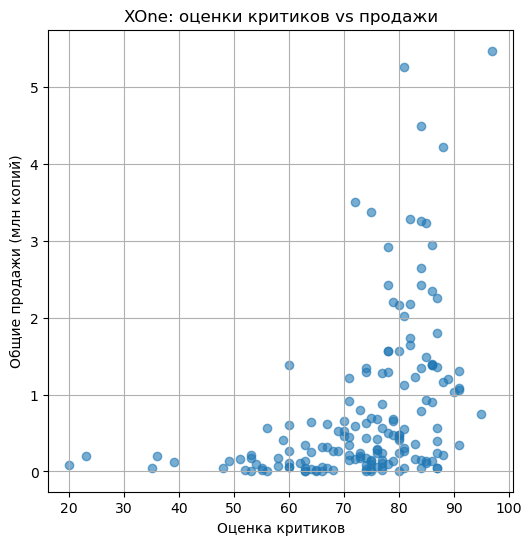

Корреляция оценка критиков ↔ общие продажи: 0.41


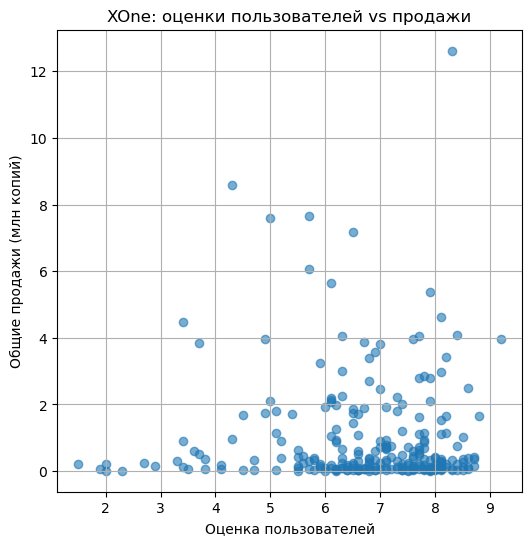

Корреляция оценка пользователей ↔ общие продажи: -0.094


In [52]:
xone = (
    data_act
    .loc[data_act['platform']=='XOne', 
         ['critic_score','user_score','total_sales']]
    .dropna()
)
plt.figure(figsize=(6,6))
plt.scatter(xone['critic_score'], xone['total_sales'], alpha=0.6)
plt.xlabel('Оценка критиков')
plt.ylabel('Общие продажи (млн копий)')
plt.title('XOne: оценки критиков vs продажи')
plt.grid()
plt.show()
corr_matrix = xone.corr()
print('Корреляция оценка критиков ↔ общие продажи:', round(corr_matrix.loc['critic_score','total_sales'],3))
plt.figure(figsize=(6,6))
plt.scatter(ps4['user_score'], ps4['total_sales'], alpha=0.6)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общие продажи (млн копий)')
plt.title('XOne: оценки пользователей vs продажи')
plt.grid()
plt.show()

print('Корреляция оценка пользователей ↔ общие продажи:', round(corr_matrix.loc['user_score'  ,'total_sales'],3))

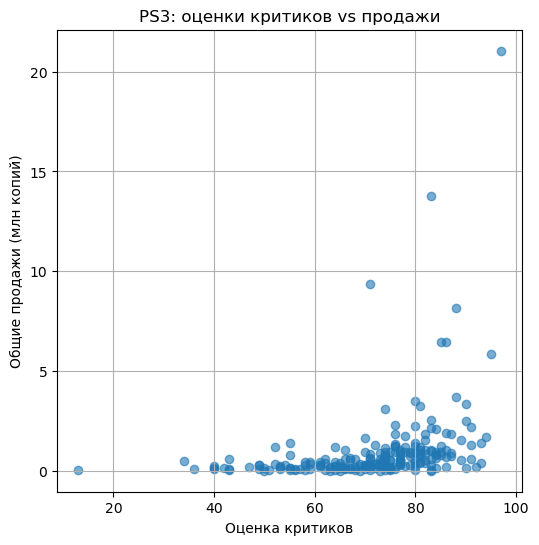

Корреляция оценка критиков ↔ общие продажи: 0.331


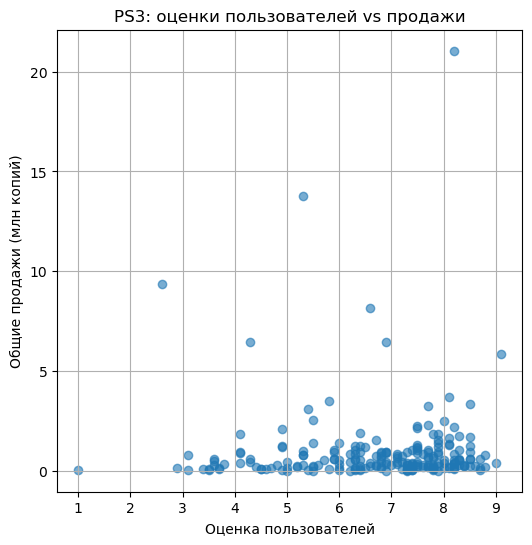

Корреляция оценка пользователей ↔ общие продажи: 0.003


In [53]:
ps3 = (
    data_act
    .loc[data_act['platform']=='PS3', 
         ['critic_score','user_score','total_sales']]
    .dropna()
)
plt.figure(figsize=(6,6))
plt.scatter(ps3['critic_score'], ps3['total_sales'], alpha=0.6)
plt.xlabel('Оценка критиков')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS3: оценки критиков vs продажи')
plt.grid()
plt.show()
corr_matrix = ps3.corr()
print('Корреляция оценка критиков ↔ общие продажи:', round(corr_matrix.loc['critic_score','total_sales'],3))
plt.figure(figsize=(6,6))
plt.scatter(ps3['user_score'], ps3['total_sales'], alpha=0.6)
plt.xlabel('Оценка пользователей')
plt.ylabel('Общие продажи (млн копий)')
plt.title('PS3: оценки пользователей vs продажи')
plt.grid()
plt.show()

print('Корреляция оценка пользователей ↔ общие продажи:', round(corr_matrix.loc['user_score'  ,'total_sales'],3))

- пользователи из Европы и Америки в целом очень похожи, отличается только основная платформа для игр, но жанры в топ-4 полностью совпадают, в то же время в Японии картина совсем другая

                                       Доля, %     Категория
Регион           Тип          Место                         
Европа           Жанр         1      31.439170        Action
                              2      22.388619       Shooter
                              3      13.632059        Sports
                              4       9.575392  Role-Playing
                              5       5.384555        Racing
                 Платформа    1      27.838286           PS4
                              2      21.084409           PS3
                              3      14.703445          X360
                              4      10.179156          XOne
                              5       8.413243           3DS
                 Рейтинг ESRB 1      38.269997             M
                              2      22.301803             E
                              3      18.053747            NR
                              4      10.924983          E10+
                        

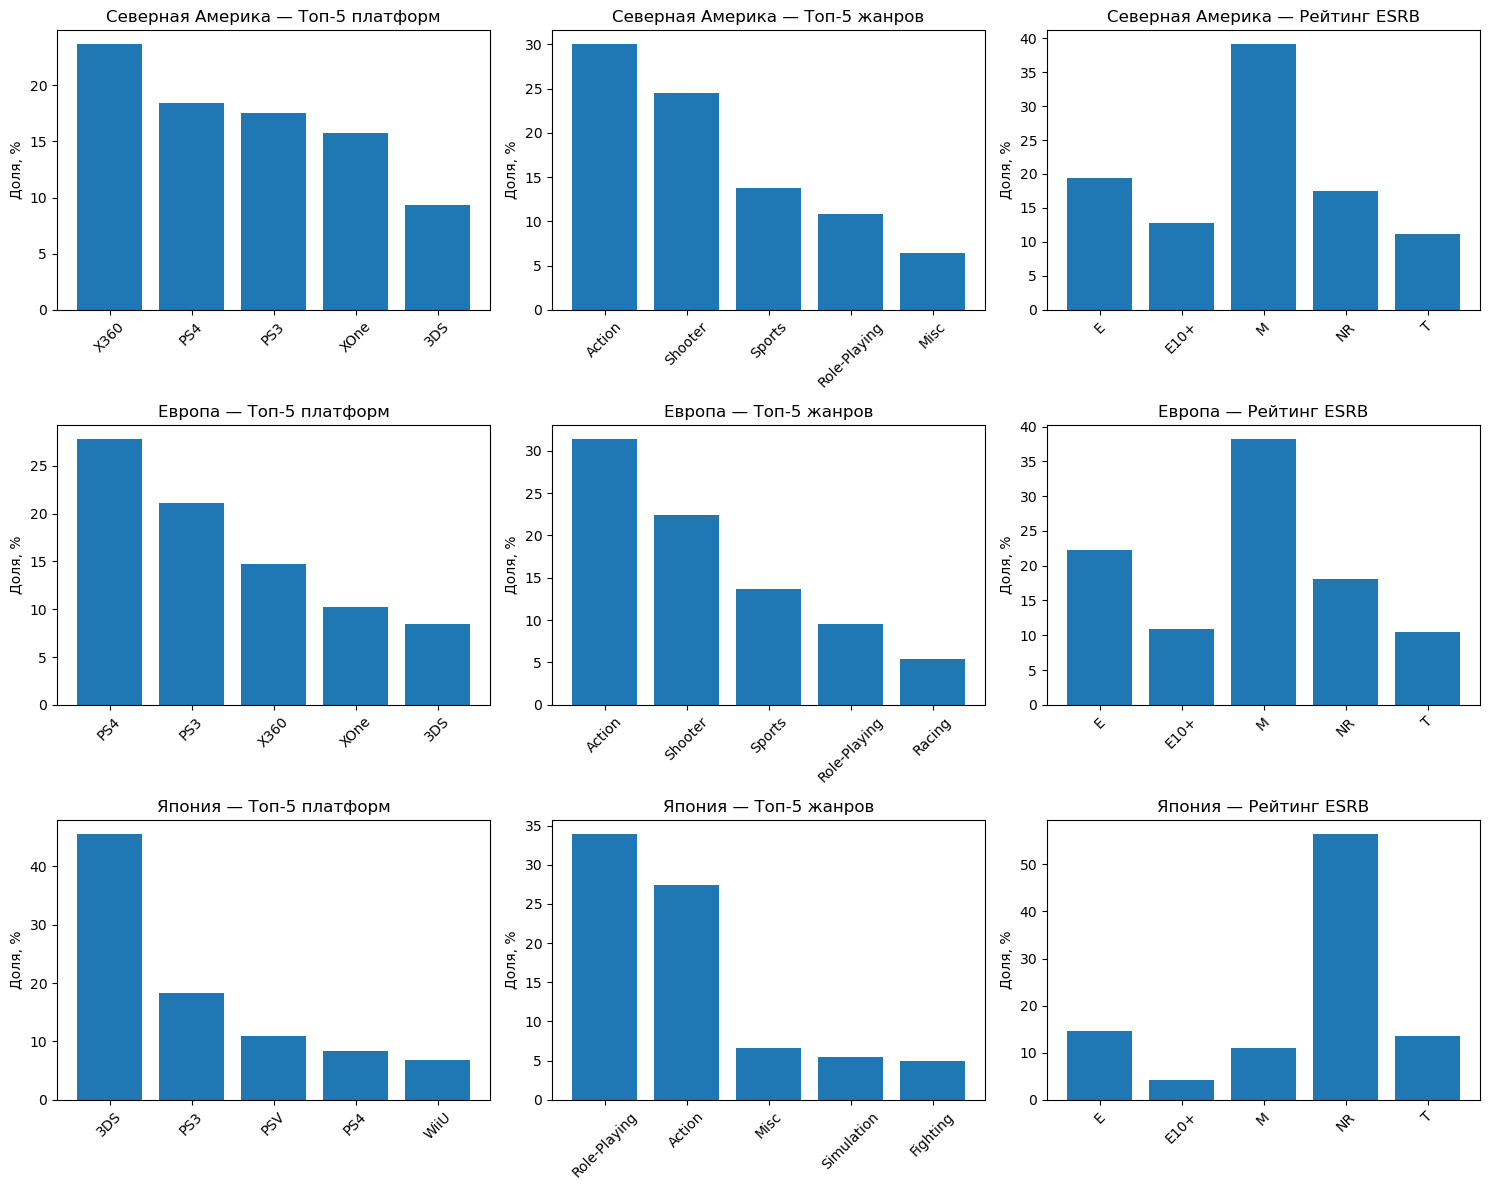

In [55]:
regions = {
    'na_sales': 'Северная Америка',
    'eu_sales': 'Европа',
    'jp_sales': 'Япония',
}

rows = []
for col, region in regions.items():
    total = data_act[col].sum()
    top_plat = (
        data_act
        .groupby('platform')[col]
        .sum()
        .nlargest(5)
    )
    top_gen  = (
        data_act
        .groupby('genre')[col]
        .sum()
        .nlargest(5)
    )
    dist_rat = (
        data_act
        .groupby('rating')[col]
        .sum()
        .sort_values(ascending=False)
    )

    for i, (plat, val) in enumerate(top_plat.items(), 1):
        rows.append([region, 'Платформа',    i, plat, val/total*100])
    for i, (gen, val) in enumerate(top_gen.items(), 1):
        rows.append([region, 'Жанр',          i, gen,  val/total*100])
    for i, (rat, val) in enumerate(dist_rat.items(), 1):
        rows.append([region, 'Рейтинг ESRB', i, rat,  val/total*100])

report = pd.DataFrame(rows, columns=['Регион','Тип','Место','Категория','Доля, %'])
pivot = report.pivot_table(
    index=['Регион','Тип','Место'],
    values=['Категория','Доля, %'],
    aggfunc={'Категория':'first','Доля, %':'first'}
).sort_index()

print(pivot)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, (col, region) in enumerate(regions.items()):
    s_plat = data_act.groupby('platform')[col].sum()
    s_plat = (s_plat / s_plat.sum() * 100).nlargest(5)
    axes[3*i].bar(s_plat.index, s_plat.values)
    axes[3*i].set_title(f'{region} — Топ-5 платформ')
    axes[3*i].tick_params(axis='x', rotation=45)
    axes[3*i].set_ylabel('Доля, %')

    s_gen = data_act.groupby('genre')[col].sum()
    s_gen = (s_gen / s_gen.sum() * 100).nlargest(5)
    axes[3*i+1].bar(s_gen.index, s_gen.values)
    axes[3*i+1].set_title(f'{region} — Топ-5 жанров')
    axes[3*i+1].tick_params(axis='x', rotation=45)
    axes[3*i+1].set_ylabel('Доля, %')

    s_rat = data_act.groupby('rating')[col].sum()
    s_rat = s_rat / s_rat.sum() * 100
    axes[3*i+2].bar(s_rat.index, s_rat.values)
    axes[3*i+2].set_title(f'{region} — Рейтинг ESRB')
    axes[3*i+2].tick_params(axis='x', rotation=45)
    axes[3*i+2].set_ylabel('Доля, %')

plt.tight_layout()
plt.show()

Также я выяснил, что средние пользовательские рейтинги XOne и PC равны

In [57]:
xone = data_act.loc[data_act['platform']=='XOne', 'user_score'].dropna()
pc = data_act.loc[data_act['platform']=='PC', 'user_score'].dropna()
alpha = 0.05
stat1, p1 = st.ttest_ind(xone, pc, equal_var=False)
print(f'Xbox One vs PC: t={stat1:.3f}, p={p1:.3f}')
if p1 < alpha:
    print('Отвергаем H0, средние различаются.')
else:
    print('Нет оснований отвергать H0 — средние не отличаются.')

Xbox One vs PC: t=0.600, p=0.549
Нет оснований отвергать H0 — средние не отличаются.


А вот средние пользовательские рейтинги жанров Action и Sports отличаются

In [59]:
action = data_act.loc[data_act['genre']=='Action', 'user_score'].dropna()
sports = data_act.loc[data_act['genre']=='Sports','user_score'].dropna()
stat2, p2 = st.ttest_ind(action, sports, equal_var=False)
print(f'Action vs Sports:  t={stat2:.3f}, p={p2:.3f}')
if p2 < alpha:
    print('Отвергаем H0, средние различаются.')
else:
    print('Нет оснований отвергать H0 — средние не отличаются.')

Action vs Sports:  t=9.903, p=0.000
Отвергаем H0, средние различаются.


Исходя из этих данных, рекоменудуется для продаж в Америке поставлять игры в жанре Action и Shooter для X360, но стоит учитывать, что PS4 и XOne набирают популярность, для продаж в Европе рекомендуется уже основной поставок делать на PS4 в тех же жанрах, а в Японии картина другая, рекомендуется поставлять игры в жанрах Role-Playing и Action для 3DS